In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [ ]:
#MNIST -> hand written digits
#0 to 255 -> 0 to 1 
# assume they are transformed from (0, 1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
len(train_dataset)

60000

In [ ]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [ ]:
# Discriminator ANN
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [ ]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),     #28*28 -> image size of MNIST dataset
    nn.Tanh()    #-> -1 to 1     
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2   # -1 and 1 =>-1+1/2 = 0 and 1+1/2 =1
  return out

In [ ]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]


    ###########################
    ### Train discriminator ###
    ###########################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake) # real_loss+fake_loss/2
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #######################
    ### Train generator ###
    #######################

    # do it twice:
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images) #-> 0

      # reverse the labels!
      g_loss = criterion(fake_outputs, ones) #-> 1

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  ### print and save things ###
  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # PyTorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")


Epoch: 0, d_loss: 0.6883231997489929, g_loss: 0.7401008605957031
Epoch: 1, d_loss: 0.6922045946121216, g_loss: 0.6939800977706909
Epoch: 2, d_loss: 0.7303088903427124, g_loss: 0.534770131111145
Epoch: 3, d_loss: 0.6928665637969971, g_loss: 0.773463249206543
Epoch: 4, d_loss: 0.6783149838447571, g_loss: 0.7268375158309937
Epoch: 5, d_loss: 0.6888543367385864, g_loss: 0.7201693058013916
Epoch: 6, d_loss: 0.6856420636177063, g_loss: 0.6932336688041687
Epoch: 7, d_loss: 0.6863957047462463, g_loss: 0.7235294580459595
Epoch: 8, d_loss: 0.6881774663925171, g_loss: 0.7255837321281433
Epoch: 9, d_loss: 0.6854938864707947, g_loss: 0.7394787669181824
Epoch: 10, d_loss: 0.6859151721000671, g_loss: 0.7127695083618164
Epoch: 11, d_loss: 0.6867917776107788, g_loss: 0.7500686645507812
Epoch: 12, d_loss: 0.6937879323959351, g_loss: 0.7103568315505981
Epoch: 13, d_loss: 0.6849745512008667, g_loss: 0.7047750949859619
Epoch: 14, d_loss: 0.6876932382583618, g_loss: 0.6982002258300781
Epoch: 15, d_loss: 0.6

KeyboardInterrupt: ignored

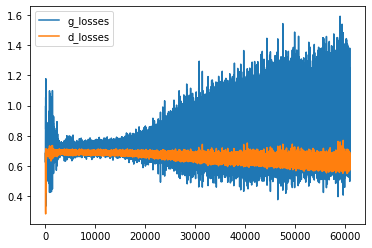

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

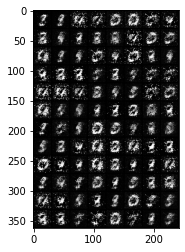

In [ ]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

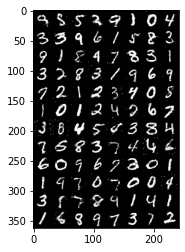

In [ ]:
a = imread('gan_images/50.png')
plt.imshow(a)

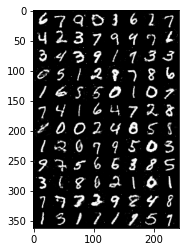

In [ ]:
a = imread('gan_images/100.png')
plt.imshow(a)

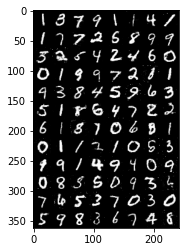

In [ ]:
a = imread('gan_images/127.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/200.png')
plt.imshow(a)